# Watch Movement Classification
<hr>

Date : 22/02/2023  
Auteur : Gaël Penessot  
email : gaelpenessot@data-decision.io  
  
This notebook is a POC for watch movement classification based on CNN (VGG & ResNet).

## 1. Load and preprocess images

In [34]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard, LambdaCallback
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras import datasets, layers, models, losses, Model, Sequential, Input
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input as preprocess_effB7
import h5py

In [2]:
print(tf.__version__)

2.10.0


In [3]:
data_dir = r'C:/Users/gaelp/Documents/watch_app/movement_database/'

## Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 16
img_height = 256
img_width = 256

It's good practice to use a validation split when developing your model. I use 80% of the images for training and 20% for validation.

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  #shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 716 files belonging to 17 classes.
Using 573 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  #shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 716 files belonging to 17 classes.
Using 143 files for validation.


You can find the class names in the `class_names` attribute on these datasets.

In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['Angelus 210', 'Angelus 215', 'Buren 1281', 'Excelsior 4X', 'Hanhart 40', 'Landeron 148', 'Landeron 248', 'Landeron 39', 'Landeron 48 54', 'Mido 1300', 'Pierce 134', 'Urofa 59', 'Valjoux 22', 'Valjoux 7730', 'Valjoux 92', 'Venus 170', 'Venus 175']


### Visualize the data

Here are the first nine images from the training dataset.

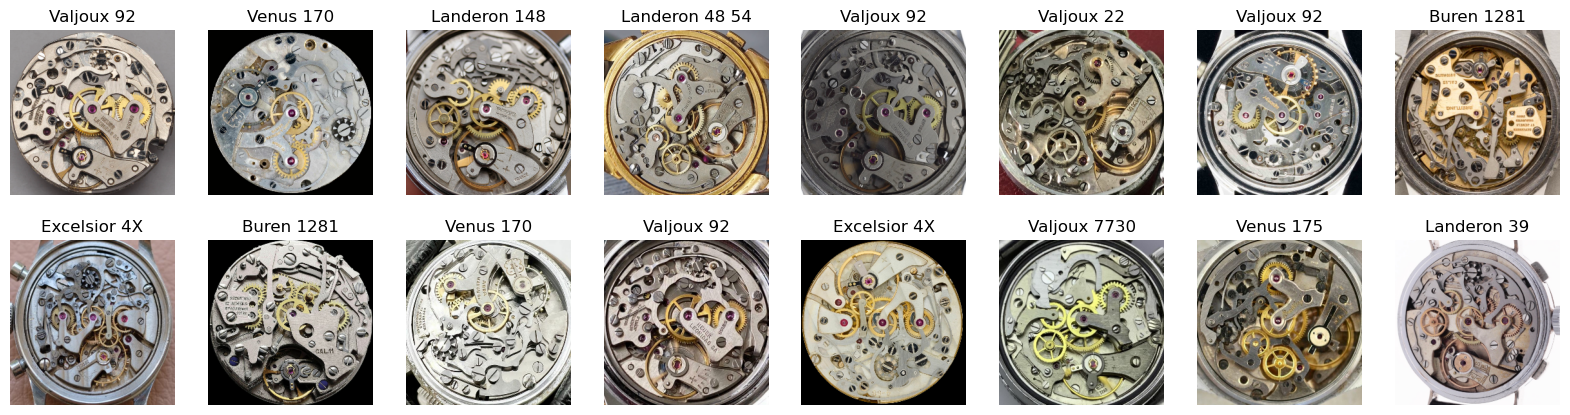

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(2, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [39]:
# Checking dimensions
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 256, 256, 3)
(16,)


The `image_batch` is a tensor of the shape `(16, 256, 256, 3)`. This is a batch of 16 images of shape `256x256x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(16,)`, these are corresponding labels to the 16 images.

### Standardize the data


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, you can include the layer inside your model definition to simplify deployment. You will use the second approach here.

Note: If you would like to scale pixel values to `[-1,1]` you can instead write `tf.keras.layers.Rescaling(1./127.5, offset=-1)`

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

I train an [EfficientNet B7](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB7) model with a data augmentation layer in order to have a better performance with this small dataset. Let's see if it's enough. 

### Data augmentation layer

I choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, I pass the `metrics` argument to `Model.compile`.

In [13]:
img_augmentation = tf.keras.Sequential([layers.RandomRotation(0.25)])

In [14]:
def build_model(num_classes):
    inputs = layers.Input(shape=(img_height, img_width, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB7(include_top=False, 
                           input_tensor=x, 
                           #weights="imagenet"
                           )

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics=["accuracy"]
    )
    return model

Now let's build the model.

In [15]:
with tf.device("/cpu:0"):
    model = build_model(num_classes)
#model.summary()

In [16]:
with tf.device("/cpu:0"):
    history = model.fit(train_ds,
                        validation_data=val_ds, 
                        epochs=40)

Epoch 1/40
36/36 [==============================] - 157s 4s/step - loss: 3.4787 - accuracy: 0.0803 - val_loss: 2.7065 - val_accuracy: 0.1888
Epoch 2/40
36/36 [==============================] - 146s 4s/step - loss: 2.9244 - accuracy: 0.1640 - val_loss: 2.6017 - val_accuracy: 0.3007
Epoch 3/40
36/36 [==============================] - 141s 4s/step - loss: 2.5299 - accuracy: 0.2373 - val_loss: 2.4842 - val_accuracy: 0.3776
Epoch 4/40
36/36 [==============================] - 141s 4s/step - loss: 2.2716 - accuracy: 0.3072 - val_loss: 2.3496 - val_accuracy: 0.4266
Epoch 5/40
36/36 [==============================] - 142s 4s/step - loss: 2.1142 - accuracy: 0.3525 - val_loss: 2.2057 - val_accuracy: 0.4825
Epoch 6/40
36/36 [==============================] - 141s 4s/step - loss: 1.9133 - accuracy: 0.4014 - val_loss: 2.0578 - val_accuracy: 0.5035
Epoch 7/40
36/36 [==============================] - 141s 4s/step - loss: 1.8034 - accuracy: 0.4398 - val_loss: 1.9103 - val_accuracy: 0.5315
Epoch 8/40
36

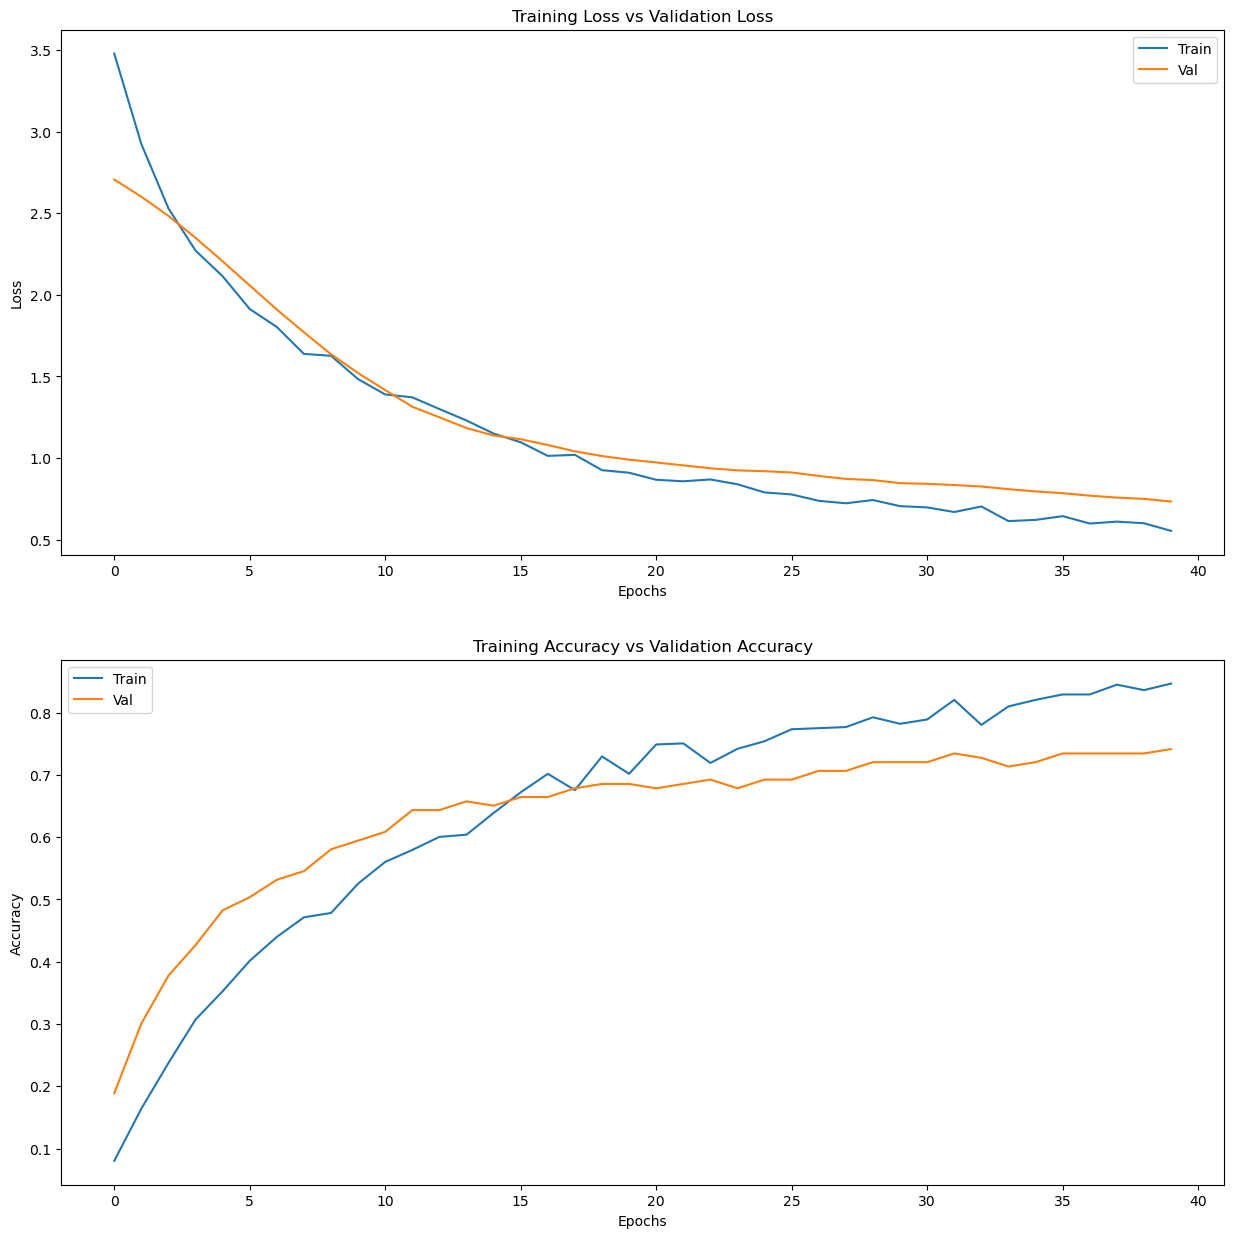

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

Let's see if we can get a better score unfreezing last layers of EfficientNet model. 

Some good practices :

**On unfreezing layers:**

* The BatchNormalization layers need to be kept frozen ([more details](https://keras.io/guides/transfer_learning/)). If they are also turned to trainable, the first epoch after unfreezing will significantly reduce accuracy.
* In some cases it may be beneficial to open up only a portion of layers instead of unfreezing all. This will make fine tuning much faster when going to larger models like B7.
* Each block needs to be all turned on or off. This is because the architecture includes a shortcut from the first layer to the last layer for each block. Not respecting blocks also significantly harms the final performance.
* Do not use the RMSprop setup as in the original paper for transfer learning. The momentum and learning rate are too high for transfer learning. It will easily corrupt the pretrained weight and blow up the loss. A quick check is to see if loss (as categorical cross entropy) is getting significantly larger than log(NUM_CLASSES) after the same epoch. If so, the initial learning rate/momentum is too high.
* Smaller batch size benefit validation accuracy, possibly due to effectively providing regularization.

In [18]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss=losses.SparseCategoricalCrossentropy(), metrics=["accuracy"]
    )


unfreeze_model(model)

In [19]:
with tf.device("/cpu:0"):
    history = model.fit(train_ds,
                        validation_data=val_ds, 
                        epochs=10)

Epoch 1/10
36/36 [==============================] - 155s 4s/step - loss: 0.5565 - accuracy: 0.8307 - val_loss: 0.7243 - val_accuracy: 0.7413
Epoch 2/10
36/36 [==============================] - 140s 4s/step - loss: 0.5331 - accuracy: 0.8464 - val_loss: 0.7099 - val_accuracy: 0.7273
Epoch 3/10
36/36 [==============================] - 138s 4s/step - loss: 0.5122 - accuracy: 0.8621 - val_loss: 0.7068 - val_accuracy: 0.7413
Epoch 4/10
36/36 [==============================] - 137s 4s/step - loss: 0.4826 - accuracy: 0.8743 - val_loss: 0.6954 - val_accuracy: 0.7413
Epoch 5/10
36/36 [==============================] - 214s 6s/step - loss: 0.5027 - accuracy: 0.8621 - val_loss: 0.6834 - val_accuracy: 0.7552
Epoch 6/10
36/36 [==============================] - 150s 4s/step - loss: 0.4538 - accuracy: 0.8761 - val_loss: 0.6619 - val_accuracy: 0.7483
Epoch 7/10
36/36 [==============================] - 151s 4s/step - loss: 0.4678 - accuracy: 0.8604 - val_loss: 0.6592 - val_accuracy: 0.7622
Epoch 8/10
36

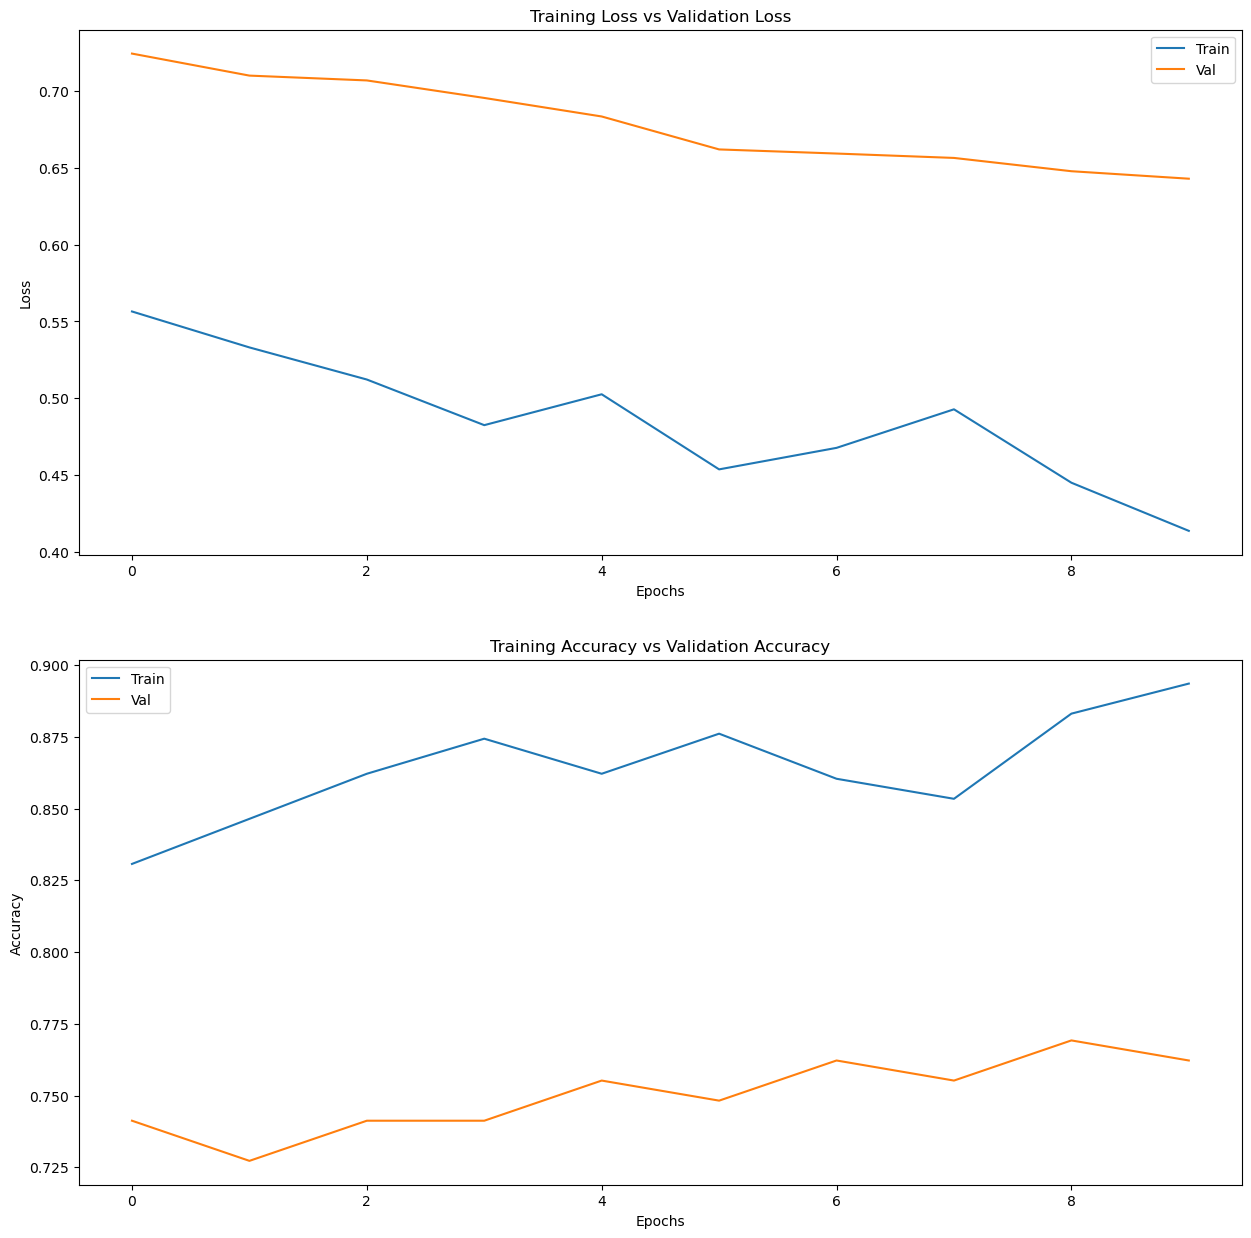

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [21]:
model.save('/models/model_EfficientNetB7_24022023')

INFO:tensorflow:Assets written to: /models/model_EfficientNetB7_24022023\assets


INFO:tensorflow:Assets written to: /models/model_EfficientNetB7_24022023\assets


In [22]:
def get_img_array(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [31]:
img_path = 'test_image_2.jpg'
test_img = get_img_array(img_path, (256, 256, 3))

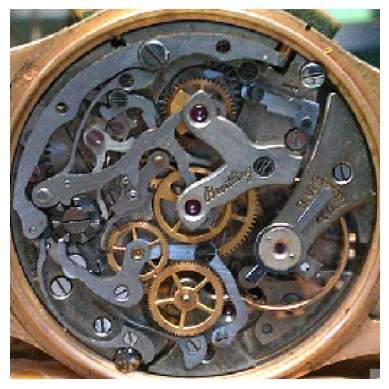

In [32]:
plt.axis('off')
plt.imshow(test_img[0].astype('uint8'))
plt.show()

In [33]:
with tf.device("/cpu:0"):
    preds = model.predict(test_img)
    print("Predicted:", class_names[np.argmax(preds)])

1/1 [==============================] - 0s 344ms/step
Predicted: Venus 175
